# Data Mining Practical-03-B

**Student name:** Patrick Keogh

**Student number:** 19321326

## Question 1: K-Means Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Load data
df = pd.read_csv('specs/question_1.csv')
df.head(5)

,x,y,org_cluster
0,10.9,12.6,2
1,2.3,8.4,1
2,8.4,12.6,1
3,12.1,16.2,2
4,7.3,8.9,1


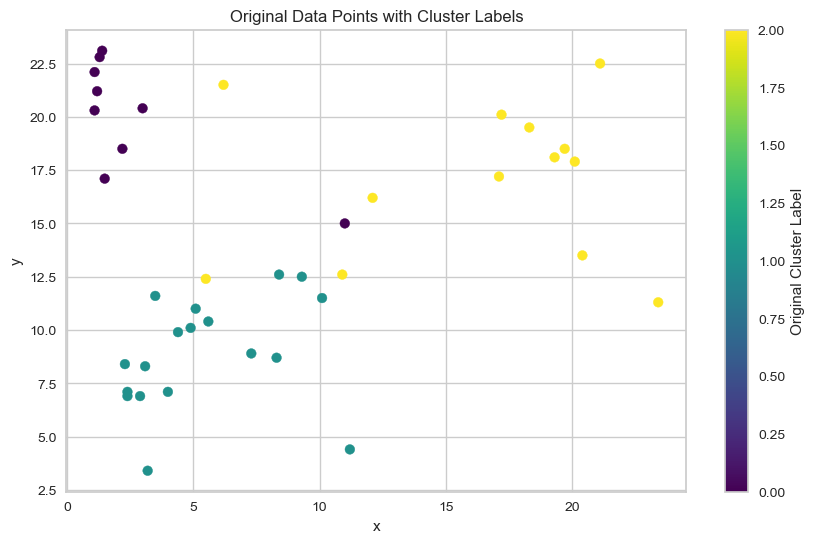

In [3]:
# 1. Visualise the original data points with different colours for their original cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['org_cluster'], cmap='viridis', marker='o')
plt.title("Original Data Points with Cluster Labels")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label='Original Cluster Label')
plt.show()

In [4]:
# 2. K-Means clustering to determine the best number of clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')  
    kmeans.fit(df[['x', 'y']])
    inertia.append(kmeans.inertia_)
inertia

[3128.5874999999996,
 1491.4626666666668,
 596.7176349206349,
 387.53162698412694,
 368.13593253968247,
 293.53011752136746,
 229.02081349206347,
 145.55255952380952,
 124.9392261904762,
 102.53880952380953]

In [5]:
points = np.column_stack((k_range, inertia))

first_point = points[0]
last_point = points[-1]

line_vec = last_point - first_point
line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
point_vec = points - first_point
proj_lengths = np.dot(point_vec, line_vec_norm)
proj_vec = np.outer(proj_lengths, line_vec_norm)
distances = np.sqrt(np.sum((point_vec - proj_vec)**2, axis=1))

elbow_index = np.argmax(distances)
elbow_point = k_range[elbow_index]

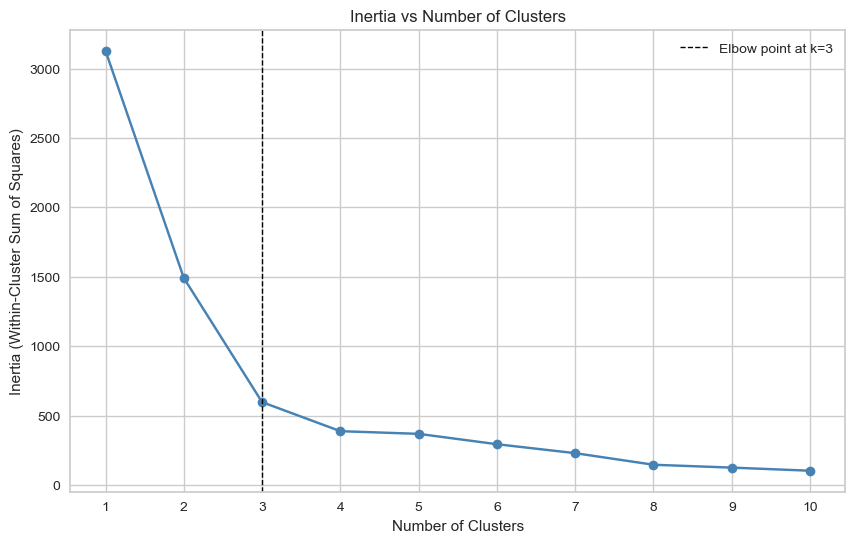

In [6]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', color='steelblue')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_range)

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='black', linestyle='--', label=f'Elbow point at k={elbow_point}', linewidth=1)
plt.legend()
plt.show()

As we can see from the above graph, the elbow is at k=3, meaning 3 clusters is the optimal number of clusters for this dataset

In [7]:
# 3. K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(df[['x', 'y']])

rand_index = adjusted_rand_score(df['org_cluster'], df['kmeans_cluster'])
silhouette_score_value = silhouette_score(df[['x', 'y']], df['kmeans_cluster'])

print(f"Rand Index: {rand_index}")
print(f"Silhouette Score: {silhouette_score_value}")

Rand Index: 0.7101262837417722
Silhouette Score: 0.6093075207861812


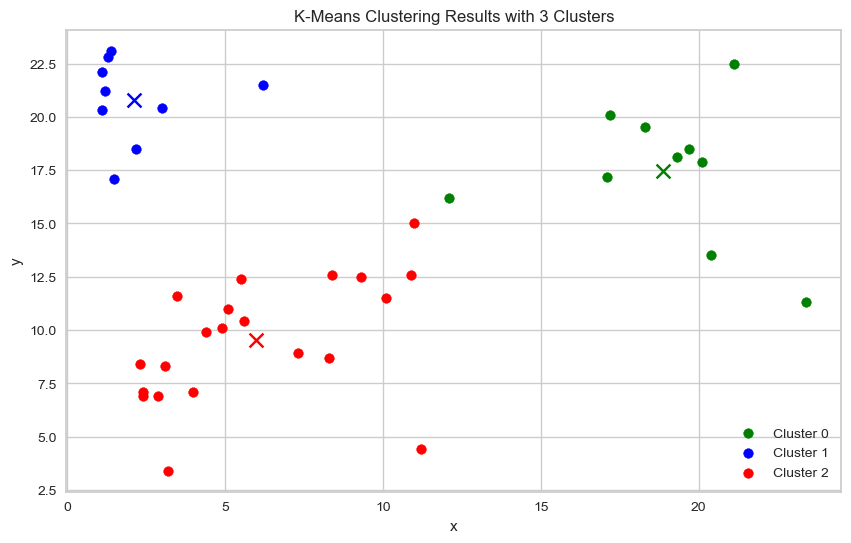

In [8]:
plt.figure(figsize=(10, 6))
colors = ['green','blue','red'] 
for i, color in enumerate(colors):
    cluster_data = df[df['kmeans_cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'], c=[color], label=f'Cluster {i}', marker='o')

centroids = kmeans.cluster_centers_
for i, color in enumerate(colors):
    plt.scatter(centroids[i, 0], centroids[i, 1], c=[color], marker='x', s=100)

plt.title("K-Means Clustering Results with 3 Clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Question 2: K-Means Clustering

In [9]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
import numpy as np

In [10]:
# Load data
df = pd.read_csv('specs/question_2.csv')
df

,NAME,MANUF,TYPE,CALORIES,PROTEIN,FAT,SODIUM,FIBER,CARBO,SUGARS,POTASS,VITAMINS,SHELF,WEIGHT,CUPS,RATING
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193


In [11]:
# 1. Discard the columns NAME, MANUF, TYPE, and RATING
df.drop(columns=['NAME', 'MANUF', 'TYPE', 'RATING'], inplace=True)
df

,CALORIES,PROTEIN,FAT,SODIUM,FIBER,CARBO,SUGARS,POTASS,VITAMINS,SHELF,WEIGHT,CUPS
0,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33
1,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00
2,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33
3,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50
4,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...
72,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75
73,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00
74,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67
75,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00


In [12]:
# 2. Run K-Means with 5 clusters, 5 maximum runs, and 100 maximum optimization steps
kmeans_config1 = KMeans(n_clusters=5, n_init=5, max_iter=100, random_state=0)
df['config1'] = kmeans_config1.fit_predict(df)
df

,CALORIES,PROTEIN,FAT,SODIUM,FIBER,CARBO,SUGARS,POTASS,VITAMINS,SHELF,WEIGHT,CUPS,config1
0,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,0
1,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,2
2,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,0
3,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,0
4,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,3
73,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,1
74,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,3
75,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,4


In [13]:
# 3. Run K-Means again with 100 maximum runs and 100 maximum optimization steps
kmeans_config2 = KMeans(n_clusters=5, n_init=100, max_iter=100, random_state=0)
df['config2'] = kmeans_config2.fit_predict(df)
df

,CALORIES,PROTEIN,FAT,SODIUM,FIBER,CARBO,SUGARS,POTASS,VITAMINS,SHELF,WEIGHT,CUPS,config1,config2
0,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,0,4
1,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,2,2
2,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,0,4
3,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,0,4
4,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,3,0
73,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,1,3
74,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,3,1
75,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,4,1


In [14]:
def config_scores(df, config_column):
    silhouette = silhouette_score(df.drop(columns=[config_column]), df[config_column])
    print(f"{config_column} Silhouette score: {silhouette}")
    return silhouette

In [15]:
# Compare clustering results of config1 and config2
config_comparison = (df['config1'] != df['config2']).sum()
print(f"Number of differing labels between config1 and config2: {config_comparison}")

# Evaluate each configuration
silhouette_config1  = config_scores(df.drop(columns=['config2'], inplace=False), 'config1')
silhouette_config2 = config_scores(df.drop(columns=['config1'], inplace=False), 'config2')

Number of differing labels between config1 and config2: 60
config1 Silhouette score: 0.33534660622246004
config2 Silhouette score: 0.3601346535452705


As we can see, there is significant difference between the two methods, with 60 differences in the clustering labels. We can also see that the performance of config 2 is superior, as it has a higher Silhouette score, which is in-line with expectations

In [16]:
# 4. Run K-Means with 3 clusters
kmeans_config3 = KMeans(n_clusters=3, n_init=5, random_state=0)
df['config3'] = kmeans_config3.fit_predict(df)
df

,CALORIES,PROTEIN,FAT,SODIUM,FIBER,CARBO,SUGARS,POTASS,VITAMINS,SHELF,WEIGHT,CUPS,config1,config2,config3
0,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,0,4,2
1,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,2,2,1
2,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,0,4,2
3,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,0,4,2
4,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,3,0,0
73,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,1,3,0
74,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,3,1,0
75,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,4,1,0


In [17]:
def plot_config(data, column, title):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data.drop(columns=[column]))

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df[column])
    plt.title(f"Cluster Visualization for {title}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

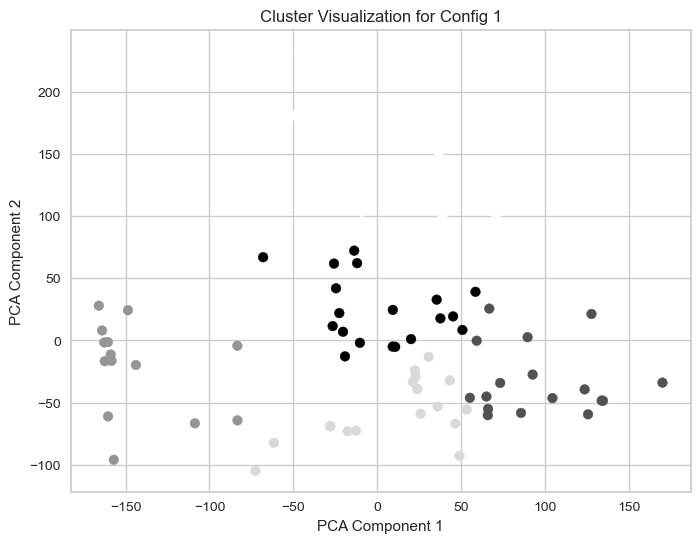

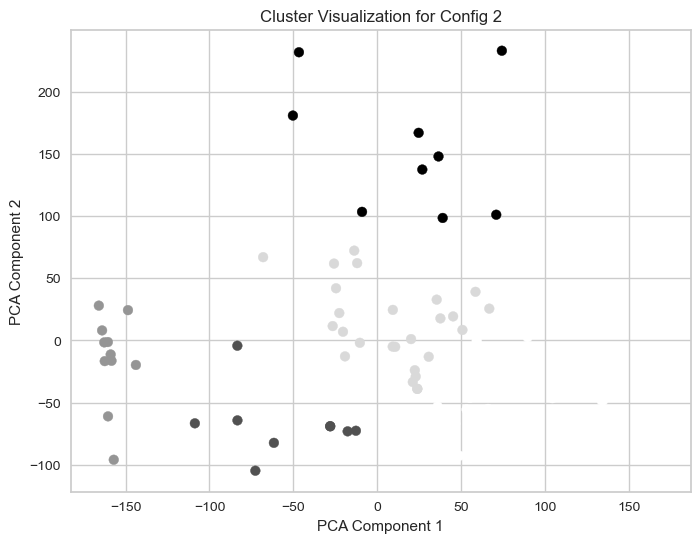

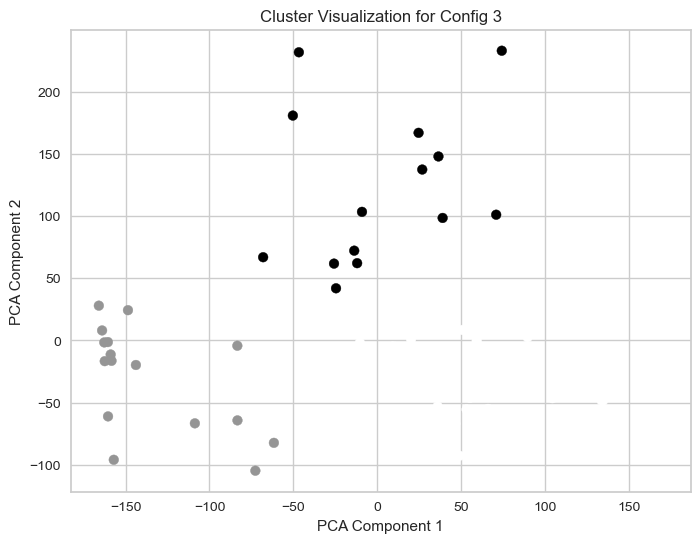

In [18]:
plot_config(df, 'config1', 'Config 1')
plot_config(df, 'config2', 'Config 2')
plot_config(df, 'config3', 'Config 3')

In [19]:
def calculate_cluster_stability(data, kmeans_params, features):
    stability_scores = []
    for _ in range(30):
        # Resample the data
        subsample = resample(data[features], random_state=0)

        # Create new instances of KMeans model for original and subsample data
        original_kmeans = KMeans(**kmeans_params)
        subsample_kmeans = KMeans(**kmeans_params)

        # Perform clustering on the original data
        original_clusters = original_kmeans.fit(data[features])

        # Perform clustering on the subsample
        subsample_clusters = subsample_kmeans.fit(subsample)

        # Calculate Adjusted Rand Index
        ari_score = adjusted_rand_score(original_clusters.labels_, subsample_clusters.labels_)
        stability_scores.append(ari_score)

    # Calculate average ARI score as a measure of stability
    average_stability = np.mean(stability_scores)
    return average_stability

In [20]:
features = df.columns.drop(['config1', 'config2', 'config3'])
models = [KMeans(n_clusters=5, n_init=5, max_iter=100, random_state=0), 
          KMeans(n_clusters=5, n_init=100, max_iter=100, random_state=0), 
          KMeans(n_clusters=3, n_init=5, random_state=0)]

In [21]:
silhouette_config1  = config_scores(df.drop(columns=['config2','config3'], inplace=False), 'config1')
silhouette_config2 = config_scores(df.drop(columns=['config1','config3'], inplace=False), 'config2')
silhouette_config3  = config_scores(df.drop(columns=['config1','config2'], inplace=False),'config3')

config1 Silhouette score: 0.33534660622246004
config2 Silhouette score: 0.3601346535452705
config3 Silhouette score: 0.46430924739274937


In [22]:
# Define the KMeans parameters for each configuration
kmeans_params1 = {'n_clusters': 5, 'n_init': 5, 'max_iter': 100, 'random_state': 0}
kmeans_params2 = {'n_clusters': 5, 'n_init': 100, 'max_iter': 100, 'random_state': 0}
kmeans_params3 = {'n_clusters': 3, 'n_init': 5, 'random_state': 0}

# Calculate stability for each configuration
cluster_stability1 = calculate_cluster_stability(df, kmeans_params1, features)
cluster_stability2 = calculate_cluster_stability(df, kmeans_params2, features)
cluster_stability3 = calculate_cluster_stability(df, kmeans_params3, features)

print(f"Cluster Stability (config 1): {cluster_stability1}")
print(f"Cluster Stability (config 2): {cluster_stability2}")
print(f"Cluster Stability (config 3): {cluster_stability3}")

Cluster Stability (config 1): 0.01642918085650138
Cluster Stability (config 2): -0.008612147325289527
Cluster Stability (config 3): -0.05253807106598987


1. **Silhouette Scores**:
   - The silhouette scores for the three configurations (`config1`, `config2`, `config3`) are 0.3354, 0.3601, and 0.4642, respectively.
   - The silhouette score ranges from -1 to 1, where a high value indicates that the clusters are well-separated and dense. 
   - Based on these scores, `config3` (with a score of 0.4642) has the best-defined clusters among the three configurations.


2. **Cluster Stability**:
   - The cluster stability scores are 0.0164, -0.0086, and -0.0525 for `config1`, `config2`, and `config3`, respectively.
   - The Adjusted Rand Index (ARI) used for these calculations also ranges from -1 to 1, where a higher value indicates more consistency between clusterings. A value close to 0 or negative indicates random or independent clusterings.
   - The positive value for `config1` suggests some level of consistency, though it's still quite low. The negative values for `config2` and `config3` suggest less stability in these configurations.

### Interpretation:
- **Silhouette Score**: Indicates that `config3` does the best job of creating distinct and well-separated clusters. This could be due to having a smaller number of clusters (3 vs. 5), allowing for broader and potentially more meaningful groupings.
- **Cluster Stability**: Suggests that all configurations have low stability, with `config1` being slightly better. This could imply that the clustering results are sensitive to the specific data sampled or to the initial conditions of the KMeans algorithm.

### Conclusion:
- While `config3` provides the most well-defined clusters (as per silhouette scores), its negative stability score suggests these results may not be consistent across different subsamples of the data.
- `config1`, despite having less well-defined clusters, shows some level of consistency, albeit very limited.
- Based on the results and the graphs,  I would have to choose `config3` as the best as it has by far the best Silhouette score and while the stability is lower, there is very little difference between the three configurations.

### Question 3: DBSCAN Clustering Algorithm

In [23]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [24]:
# Load data
df = pd.read_csv('specs/question_3.csv')
df

,ID,x,y
0,1150,-8.667331,41.149643
1,1151,-8.666030,41.153057
2,1152,-8.669282,41.152732
3,1153,-8.664242,41.150455
4,1154,-8.663267,41.152894
...,...,...,...
317,1470,-8.688467,41.151431
318,1471,-8.679037,41.156146
319,1473,-8.606201,41.139888
320,1474,-8.574660,41.145253


In [25]:
# 1. Discard the ID column and use K-Means for clustering
df_kmeans = df.copy()
df_kmeans.drop(columns=['ID'], inplace=True)
kmeans = KMeans(n_clusters=7, n_init=5, max_iter=100, random_state=0)
df_kmeans['k-means'] = kmeans.fit_predict(df[['x', 'y']])
df_kmeans

,x,y,k-means
0,-8.667331,41.149643,2
1,-8.666030,41.153057,2
2,-8.669282,41.152732,2
3,-8.664242,41.150455,2
4,-8.663267,41.152894,2
...,...,...,...
317,-8.688467,41.151431,5
318,-8.679037,41.156146,5
319,-8.606201,41.139888,6
320,-8.574660,41.145253,6


In [26]:
def plot_points(df, model):
    plt.figure(figsize=(10, 6))

    cluster_labels = df[model].unique()

    for label in cluster_labels:
        cluster_data = df[df[model] == label]
        if label == -1:
            plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {label}', color='black')
        else:
            plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {label}')


    plt.title(f"{model} Clustering results")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

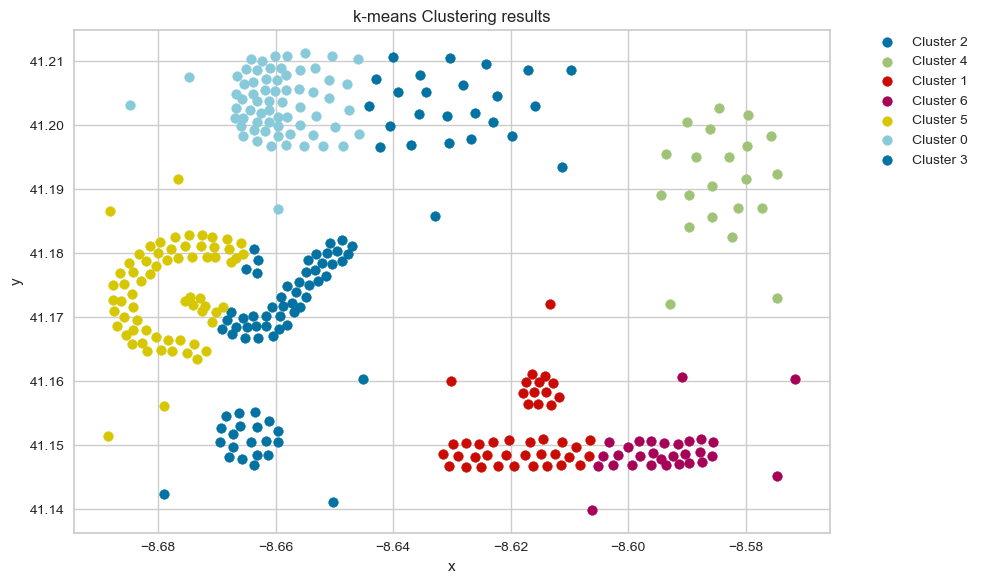

In [27]:
# 2. Plot the K-Means clustering results
plot_points(df_kmeans,'k-means')

While this model works relatively well for this dataset, it fails to note the noisy points in the data, forcing every point into a cluster. While this could be beneficial in some instances,  I think for this dataset it is less suitable as we could have used noisy point recognition as a way to clean the data or discover interesting patterns.

In [28]:
# 3. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = df_kmeans.copy()
df_scaled[['x', 'y']] = scaler.fit_transform(df_scaled[['x', 'y']])
df_scaled

,x,y,k-means
0,0.180807,0.136674,2
1,0.191933,0.184510,2
2,0.164117,0.179954,2
3,0.207232,0.148064,2
4,0.215577,0.182232,2
...,...,...,...
317,0.000000,0.161731,5
318,0.080668,0.227790,5
319,0.703755,0.000000,6
320,0.973574,0.075171,6


In [29]:
dbscan1 = DBSCAN(eps=0.4, min_samples=4, metric='euclidean')
df_scaled['dbscan1'] = dbscan1.fit_predict(df_scaled)
df_scaled

,x,y,k-means,dbscan1
0,0.180807,0.136674,2,0
1,0.191933,0.184510,2,0
2,0.164117,0.179954,2,0
3,0.207232,0.148064,2,0
4,0.215577,0.182232,2,0
...,...,...,...,...
317,0.000000,0.161731,5,4
318,0.080668,0.227790,5,4
319,0.703755,0.000000,6,3
320,0.973574,0.075171,6,3


In [30]:
def model_silhouette_score(df, model):
    silhouette = silhouette_score(df.drop(columns=[model], inplace=False), df[model])
    return silhouette

In [31]:
# Compare clustering results of config1 and config2
model_comparison = (df_scaled['k-means'] != df_scaled['dbscan1']).sum()
print(f"Number of differing labels between k-means and dbscan1: {config_comparison}")

Number of differing labels between k-means and dbscan1: 60


In [32]:
print(f"k-means Silhouette score: {model_silhouette_score(df_kmeans, 'k-means')}")
print(f"dbscan1 Silhouette score: {model_silhouette_score(df_scaled.drop(columns=['k-means'], inplace=False), 'dbscan1')}")

k-means Silhouette score: 0.49191915414623827
dbscan1 Silhouette score: 0.4273726502265168


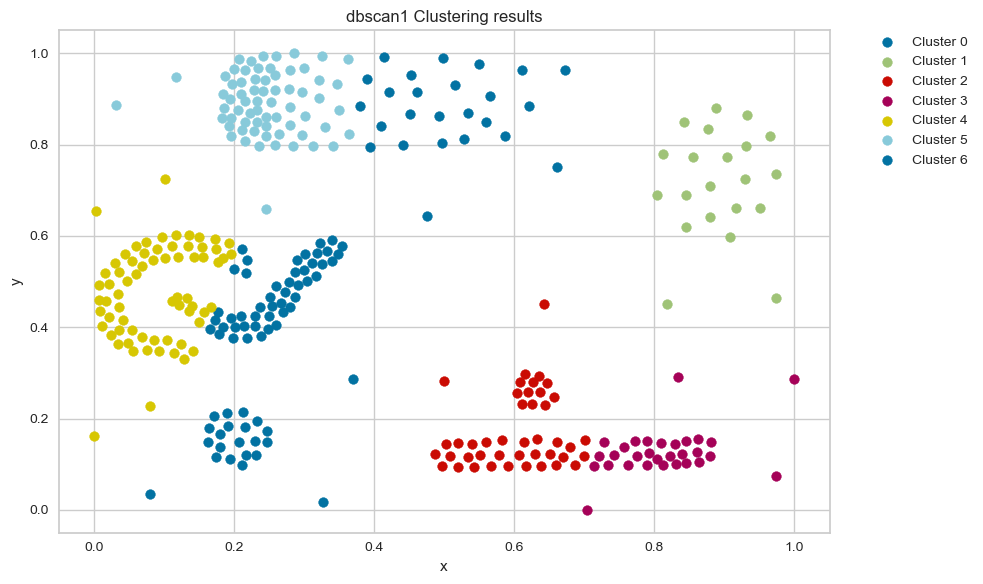

In [33]:
# Plot DBSCAN clustering results (epsilon=0.4)
plot_points(df_scaled,'dbscan1')

In [34]:
dbscan2 = DBSCAN(eps=0.08, min_samples=4, metric='euclidean')
df_scaled['dbscan2'] = dbscan2.fit_predict(df_scaled)
df_scaled

,x,y,k-means,dbscan1,dbscan2
0,0.180807,0.136674,2,0,0
1,0.191933,0.184510,2,0,0
2,0.164117,0.179954,2,0,0
3,0.207232,0.148064,2,0,0
4,0.215577,0.182232,2,0,0
...,...,...,...,...,...
317,0.000000,0.161731,5,4,-1
318,0.080668,0.227790,5,4,-1
319,0.703755,0.000000,6,3,-1
320,0.973574,0.075171,6,3,-1


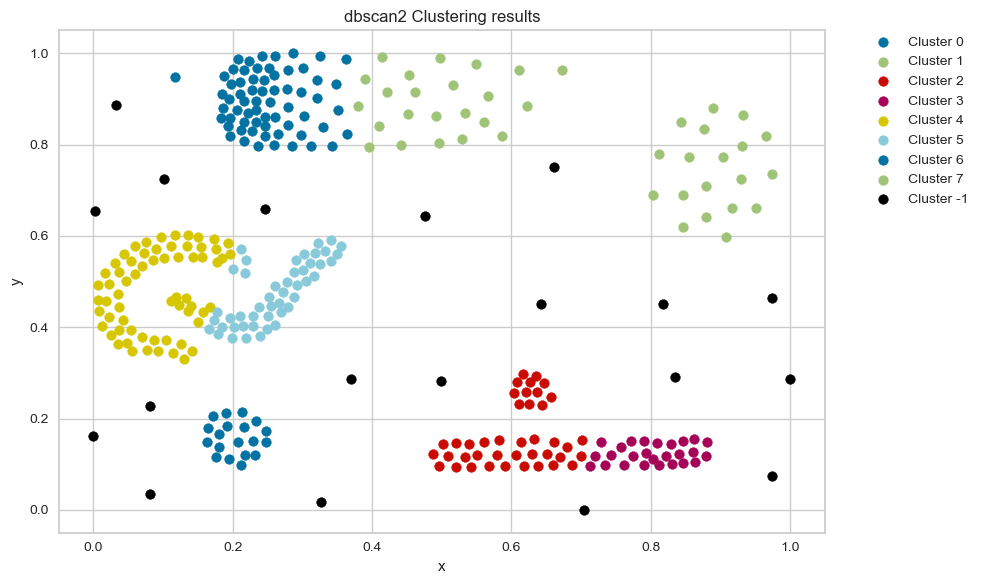

In [35]:
# Plot DBSCAN clustering results (epsilon=0.08)
plot_points(df_scaled,'dbscan2')

In [36]:
display(HTML('<b>k-means</b>'))
print(f"Silhouette score: {model_silhouette_score(df_kmeans, 'k-means')}")
display(HTML('<b>dbscan (eps=0.4)</b>'))
print(f"Silhouette score: {model_silhouette_score(df_scaled.drop(columns=['k-means','dbscan2'], inplace=False), 'dbscan1')}")
display(HTML('<b>dbscan (eps=0.08)</b>'))
print(f"Silhouette score: {model_silhouette_score(df_scaled.drop(columns=['k-means','dbscan1'], inplace=False), 'dbscan2')}")

Silhouette score: 0.49191915414623827


Silhouette score: 0.4273726502265168


Silhouette score: 0.44499651807715734


Based on the plotted graphs, we can see that dbscan eps=0.08 correctly identifies noise points on the graph and does not force them into clusters that they are not truly part of. This is useful for this particualr dataset as it helps it would help with processinf the data further and identify patterns outside the obvious cluster which were picked up by the kmeans algorithm (dbscan1 essentially performs identically to kmeans). The silhouhette score for the dbscan2 also outperforms the dbscan1. Therefore, based on this particular dataset, I would selct dbscan2 as the best, however, depending on the goal for the algorithm, kmeasns would also work. 